# Introduction
My family runs a garage, and as a recent MSc Data Science graduate, I wanted to contribute by developing a tool that forecasts how many cars are likely to come in. 
I believe this could help with shift planning and ease the burden caused by the uncertainty of when the garage will return to its normal workload after soem busy hours.

## Business needs
The forecasting needs to satisfy at least horizons: the next few hours and the next few days.
Foreseeing the next few hours and the next few days gives the operation manager the possibility to know in advance at different time frame when to call other workers to work (and when to dismess them) and when to prepare to close the garage when the full-capacity is reached. 

## Extract Transform Load
The original dataset consists of a SQL table.
Each entry records the datetime of arrival and the datetime of departure the type of vehicle and the paid amount. 

The snippet computes the number of cars for a given frequency


In [63]:
import pandas as pd
def count_cars(
    df: pd.DataFrame, arrival_col: str, departure_col: str, freq_str: str
) -> pd.Series:
    start_date = df[arrival_col].dt.date.min()
    end_date = df[arrival_col].dt.date.max()
    datetime_index = pd.date_range(start_date, end_date, freq=freq_str)
    car_count_ls = list()
    for datetime in datetime_index:
        car_count = sum(
            (datetime > df[arrival_col]) & (datetime < df[departure_col])
        )
        car_count_ls.append(car_count)
    car_count_sr = pd.Series(car_count_ls, index=datetime_index)
    return car_count_sr


The frequency chosen is the hour. A shorter time span would increase the 
computational cost without providing additional value for practical operations.

The resulting dataset can be found in `'./data/cars-per-hour.csv`.

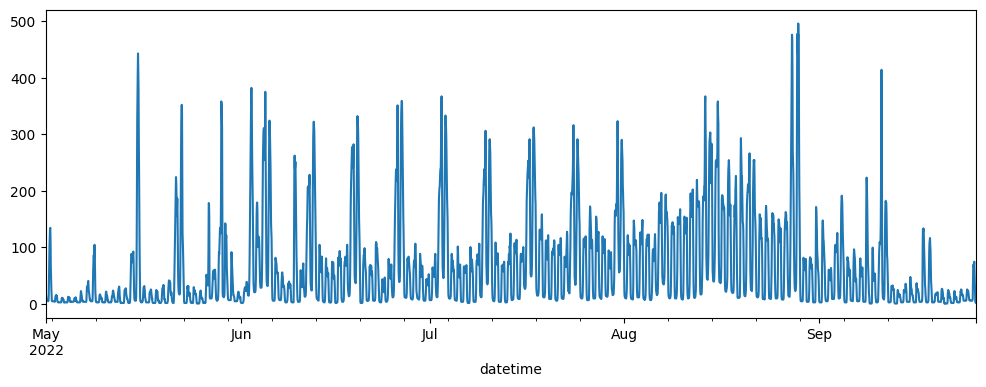

In [64]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 4)

cars = pd.read_csv("./data/cars-per-hour.csv", index_col=0, parse_dates=True)
cars.index = pd.DatetimeIndex(cars.index, freq='infer')
cars.plot(figsize=(12, 4), legend=False)
plt.show()

The time series shows the hourly car count from May to almost the end of September, 2022. 
There are: 
* a weekly period
* a daily subperiod
* saturdays and sundays have higher averages
* there is an increasing trend that peaks in the middle of august, then it dies
* a spike around June 2, and August 15, both a national holidays

In [65]:
cars.groupby(cars.index.month).mean()

,cars
datetime,
5,29.873656
6,72.045833
7,82.106183
8,97.469086
9,32.833333


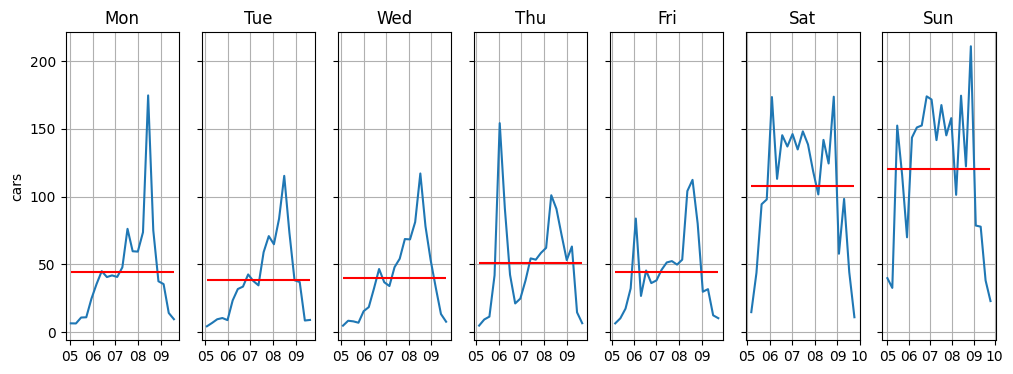

In [66]:
from matplotlib.dates import DateFormatter
from enum import StrEnum

class Period(StrEnum):
    day = "day"
    week = "week"
    month = "month"
    year = "year"

def plot_subseries(df: pd.DataFrame, column:str, period:Period):
    assert isinstance(df.index, pd.DatetimeIndex)
    assert df.index.freq is not None, "Please set the freq attr of DatetimeIndex"
    assert column in df.columns
    assert period in [Period.week, Period.month]
    weekday_name_ls = [ "Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    if period == Period.week:
        n_seasons = 7
        _, ax = plt.subplots(nrows=1, ncols=n_seasons, figsize=(12, 4), sharey=True)
        for i, (_, gb) in enumerate(df.groupby(df.index.day_of_week)):
            if not isinstance(gb.index.freq, pd.tseries.offsets.Day):
                y = gb.groupby(gb.index.normalize()).mean()
            else:
                y = gb
            ax[i].xaxis.set_major_formatter(DateFormatter('%m'))
            ax[i].tick_params("x")
            ax[i].set_title(weekday_name_ls[i])
            ax[i].plot(y)
            sub_series_avg = gb.mean()
            ax[i].hlines(sub_series_avg, y.index[0], y.index[-1], color="red")
            ax[i].set_ylabel(column)
            ax[i].label_outer()
            ax[i].grid()
    if period == Period.month:
        raise NotImplementedError

plot_subseries(cars, "cars", "week")

the blue line shows for average number of cars each month and day of the week. 
The red line shows the average number of cars for each day of the week.

The plot confirms that:
* non-working days show an average which is higher and double the average of 
working days.
* June thursdays have a higher because of June 2 national holiday happened on a
Thursday. 
* increasing trend from May to August, especially for working days. 

# Should I split the dataset into training and test sets?
In data science and machine learning, splitting the dataset into training and 
test sets is considered best practice to evaluate the performance of concurrent
models. 
This practice comes from the need to evaluate the performance of models in a 
scenario that resembles the real world, where the future information, namely the 
test set, is not available, especially when designing the model itself. 

In the context of time series modeling, though, I have seldom encoutered this practice.
People model time series using the whole dataset and relies on heuristics such as
AIC, and BIC to determine which model is best.

<!-- Indeed, why would I restrain some information available to the model 
optimization routine to the model I actually want to put in production? 
This would impede the model from having a better forecasting capability.  -->

This difference in approach reflects the differing nature of the models.
Machine learning algorithms such as support vector machines, random
forests, and k-nearest neighbors are non-parametric, and information criterions
cannot be used to determine the quality of a model because there is not an 
a priori set of the parameters to learn (they are *non-parametric*), as the model
functional form depends on size of the dataset itself. 
For example the bias vector in a support vector machine, or the classifier function
of a k-NN that depends exclusively on the traning sample.

In non-parametric models, I want to shield the model from overfitting the dataset, 
thus requiring a testing routine where information does not slip in and 
pollute the error measure. 

On the contrary, in the set of parametric models, the number of parameters
to learn does not depend on the size of the training set and information criterions
can be used for model selection; indeed, it can be shown that such heuristics 
converge to a cross validation approach, given enough data. 

Yet, it is not advised to compare a model from one family of parametric models 
agaist another (e.g. ARMA model vs ETS model) because the respective likelihood
functions differ.

With regard to this notebook, I want to compare at least two families of parametric
models.
So we will select the best model within the single family with proven heuristics 
like AIC and BIC, and compare the best model of  each family with a rolling 
origin method.

Note. From a mere lexical point of view, machine learning
algorithms encopass ARMA models as well. Yet, machine learning manuals often
do not take into consideration such models. (ref. Kevin P. Murphy, 
_Machine Learning: A Probabilistic Perspective_, or James et al.
_An introduction to Statistical Learning_, James et al.)
<!-- e l'altro manuale su 
cui ho studiato a mathematics for machine learning e quello di methods).  -->

# Modeling with ARMA
Following the Box Jenkins method (Box, G.E.P. and G.M. Jenkins (1970) Time series analysis:
Forecasting and control, San Francisco: Holden-Day.), 
the first question to ask ourselves when modeling with ARMA processes is whether
our process is (weakly) stationary.

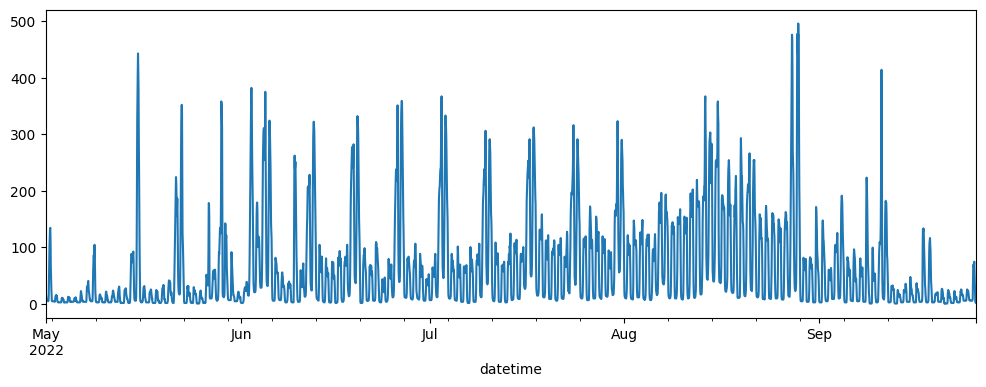

In [67]:
cars.plot(figsize=(12, 4), legend=False)
plt.show()

in our case, it is blatantly non-stationary: 
1. the variance increases up to the middle of August, fading afterward
2. it is weekly periodic, and there is a daily sub-period,

First, we stabilize the variance using the Box-Cox transformation.
and add one to avoid taking the log of a null value.

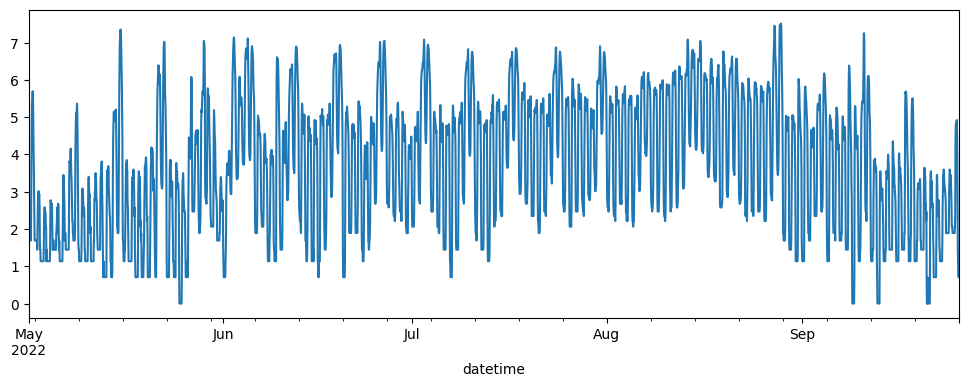

Box-Cox parameter:0.0596


In [68]:
from scipy import stats

# compute the optimal lmbda parameter
_, lmbda = stats.boxcox(cars.cars + 1)


cars['boxcox'] = cars.cars \
    .transform(lambda x: x + 1) \
    .transform(lambda x: stats.boxcox(x, lmbda)) 

cars['boxcox'].plot()
plt.show()
print(f'Box-Cox parameter:{lmbda:.4f}')


The parameter leans toward 0 rather than 0.5, implying that the variance increases almost quadratically with the trend.

Next, we deseasonalize with period equal to a week.

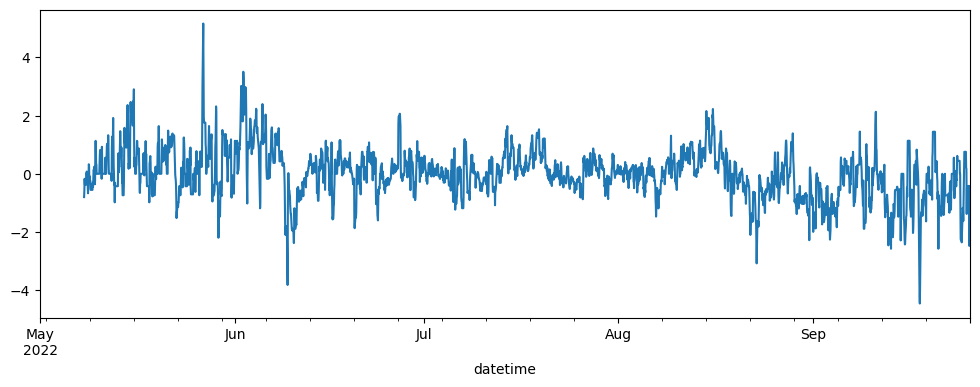

In [69]:
season = 24 * 7
cars['x'] = cars['boxcox'] - cars['boxcox'].shift(periods=season)
cars['x'].plot()
plt.show()

The time series resembles white noise. Let's test wheter it needs 
further differecing.

The augmented Dickey-Fuller statistical test assumes the a unit root
exits in the time series, implying that the time series must be differenced.

In [70]:
import statsmodels.tsa.api as tsa

p_value = tsa.adfuller(cars.x.dropna())[1]
print(f"ADF test p-value: {p_value:.4f}")

ADF test p-value: 0.0000


The null hypothesis is rejected, so no further differentiation is required.

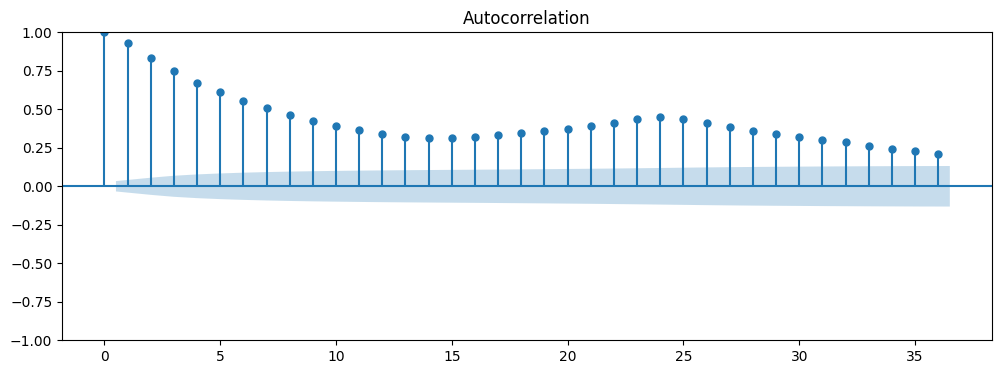

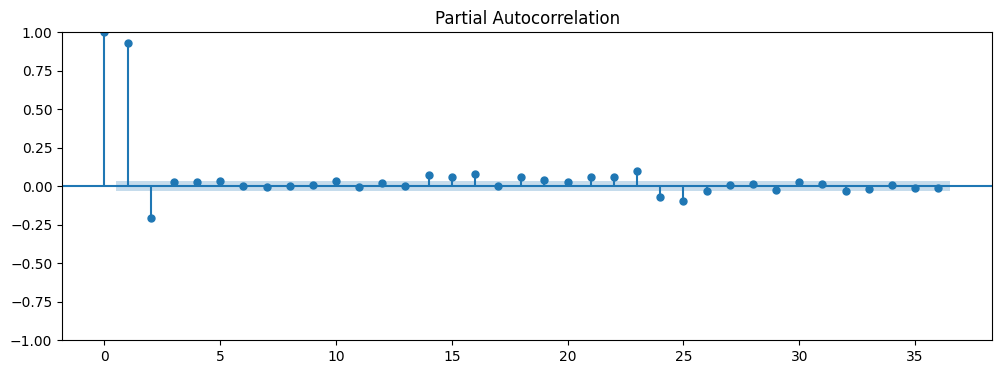

In [71]:
tsa.graphics.plot_acf(cars.x.dropna())
tsa.graphics.plot_pacf(cars.x.dropna())
plt.show()

The sample autocorrelation function (ACF) and sample partial autocorrelation function (PACF) suggests an autoregressive model $AR(p)$, with $p \leq 2$ because:
* the ACF decays expotentially up until the 24-hour lag.
* the PACF are below the 95% threshold after the third lag.

Let's investigate the periodic patterns extending the function to incorporate the weekly period.

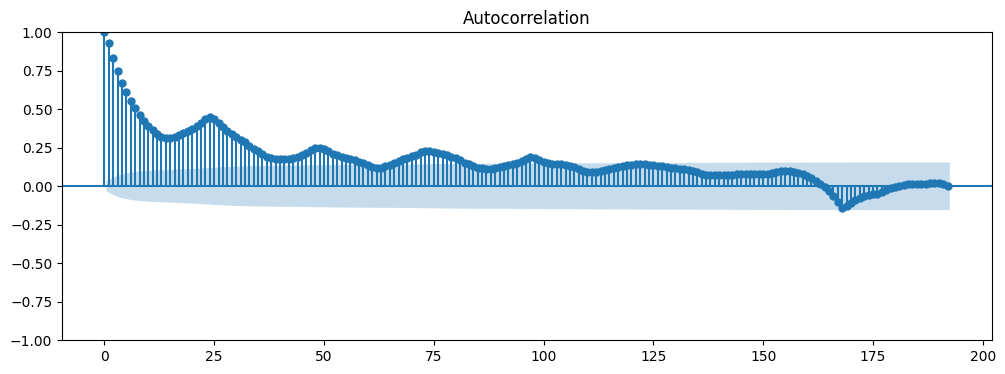

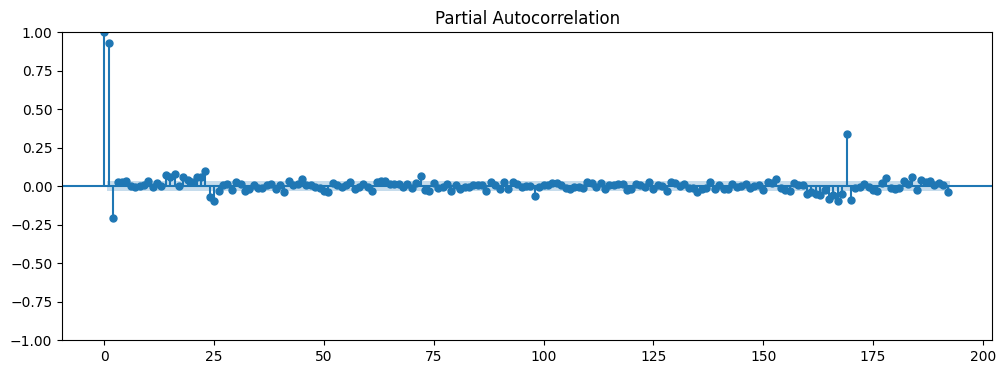

In [72]:
tsa.graphics.plot_acf(cars.x.dropna(), lags=24 * 8)
tsa.graphics.plot_pacf(cars.x.dropna(), lags=24 * 8)
plt.show()

The extended ACF and PACF shows that not all periodic infomration has beed extracted
the time series as the PACF shows above threshold values around 24-hour lag and 168-hour lag.

Let us apply a second order seasonal difference

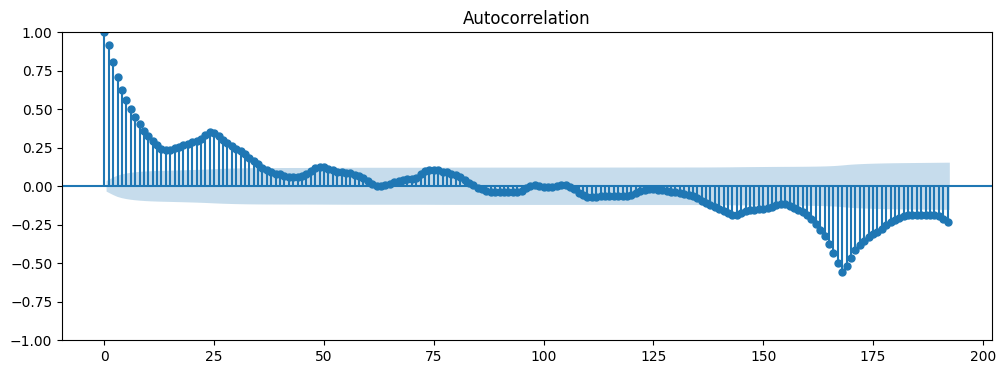

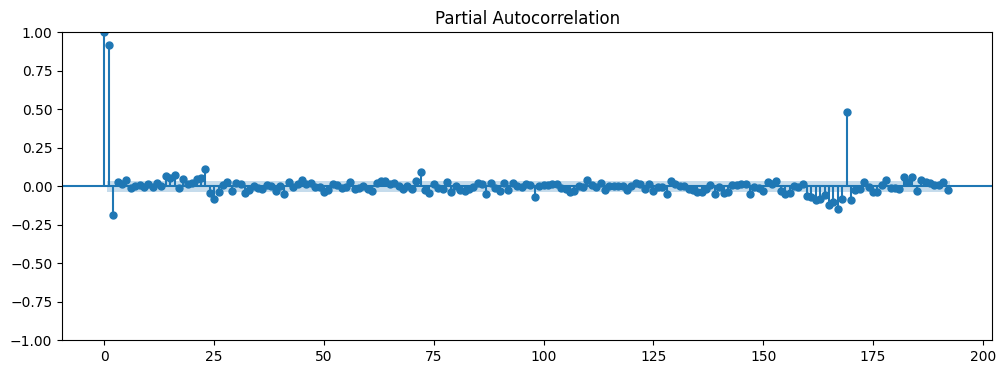

In [73]:
y = cars.x - cars.x.shift(24*7)
tsa.graphics.plot_acf(y.dropna(), lags=24 * 8)
tsa.graphics.plot_pacf(y.dropna(), lags=24 * 8)
plt.show()

The PACF above threshold values are heighten. So the differencing process is subtler
than this.

Model comparison:

In [74]:
AR1 = tsa.SARIMAX(cars.x, order=(1, 0, 0), trend='n').fit(disp=False)
AR2 = tsa.SARIMAX(cars.x, order=(2, 0, 0), trend='n').fit(disp=False)

In [75]:
print(f"AR(1) AIC: {AR1.aic:.4f}, BIC: {AR1.bic:.4f}")
print(f"AR(2) AIC: {AR2.aic:.4f}, BIC: {AR2.bic:.4f}")

AR(1) AIC: 1730.2306, BIC: 1742.5812
AR(2) AIC: 1584.8197, BIC: 1603.3455


The best model is AR(2). 

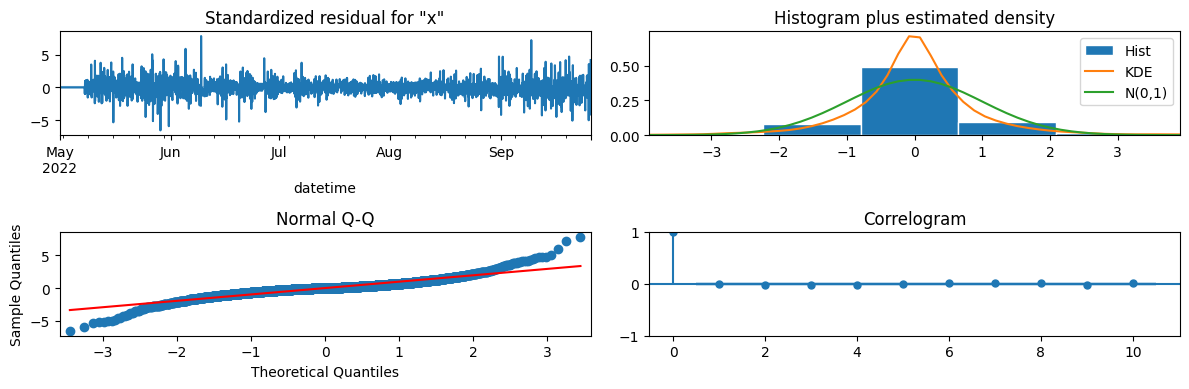

In [76]:
AR2.plot_diagnostics()
plt.tight_layout()
plt.show()

On one hand, the ACF of the residuals looks like white noise, hence the $AR(2)$ has good fit.
On the other hand, the estimated density function of the residuals show high kurtosis.
and the timeseries plot show that the majority of the samples in the tails belong 
to the months of May and June and to September.

In [77]:
print(AR2.summary())

                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations:                 3552
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -789.410
Date:                Thu, 14 Aug 2025   AIC                           1584.820
Time:                        19:53:52   BIC                           1603.346
Sample:                    05-01-2022   HQIC                          1591.426
                         - 09-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1213      0.011     99.965      0.000       1.099       1.143
ar.L2         -0.2073      0.012    -17.070      0.000      -0.231      -0.183
sigma2         0.0933      0.001     79.714      0.0

The Ljung-Box test p-value points out that the residuals are white noise 
(to be precise, one should state the the null hypothesis of residuals being independently distributed cannot be rejected, not they *are* white noise, there
is always the possibility that they are not white noise -- but leave this
quirk to statistician with a passion for theory). 

On the contrary, the already cited curtosis and the heteroskedasticity's test 
p-value show that the variance of the process is time-dependent despite of the 
Box-Cox transformation.

A natural continuation is to model the process using 
_Generalized Autoregressive Conditional Heteroskedasticity_ (GARCH) 
models that are designed to handle clusters of variance, but this is a story 
for another time.

Another attempt to handle high variance is to keep into account outliers using
dummy variables.
In this case, we can add a dummy variable whether a date is a national holiday and
a deterministic time variable. 

In [78]:
holidays_ls = ["2022-05-01", "2022-05-02", "2022-08-15"]

def date_range(date_str: str, n: int, unit: str) -> pd.Series:
    date = pd.to_datetime(date_str)
    range = pd.date_range(date, date +  pd.Timedelta(n, unit=unit), freq=unit)
    return range.to_series()

# date_range('2022-05-01', 23, 'h')
holiday_date_range_sr = pd.concat(
    list(map(lambda x: date_range(x, 23, 'h'), holidays_ls))
    )
cars['is_holiday'] = cars.index.isin(holiday_date_range_sr).astype('int')

In [79]:
AR2_ct = tsa.SARIMAX(
    endog=cars.x, 
    # exog=cars.is_holiday, 
    order=(2, 0, 0),
    trend='ct'
    ).fit(disp=False)
AR2_holiday = tsa.SARIMAX(
    endog=cars.x, 
    exog=cars.is_holiday, 
    order=(2, 0, 0),
    trend='ct'
    ).fit(disp=False)

In [80]:
print(f"Dynamic regression model with AR(2) errors")
print(f"AIC: {AR2_ct.aic:.4f}, BIC: {AR2_ct.bic:.4f}")
print(f"Dynamic regression model with AR(2) errors")
print(f"AIC: {AR2_holiday.aic:.4f}, BIC: {AR2_holiday.bic:.4f}")

Dynamic regression model with AR(2) errors
AIC: 1565.0938, BIC: 1595.9702
Dynamic regression model with AR(2) errors
AIC: 1569.7316, BIC: 1606.7831


As we can see, the increased complexity of the models improves both AIC and BIC.
Among the two, the "ct" is the best one. 

Let's wrap up the modeling so far.
The initial trasnformation are
$$
\begin{split}
z_t &  = boxcox(cars_t + 1 | \lambda) \\
x_t & = (1 - L^m) z_t \quad m = 24 * 7\\
\end{split}
$$
then, we modeled $x_t$ as a second order autoregressive model
$$ (1 - \phi_1 L - \phi_2 L^2)x_t = w_t \quad w \in WN(0, \sigma^2)$$
finally, we added a deterministic trend and and intercept:
$$ 
y_t = \beta_0 + \beta_1 t + x_t
$$

In [81]:
print(AR2_ct.summary())

                               SARIMAX Results                                
Dep. Variable:                      x   No. Observations:                 3552
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -777.547
Date:                Thu, 14 Aug 2025   AIC                           1565.094
Time:                        19:53:53   BIC                           1595.970
Sample:                    05-01-2022   HQIC                          1576.105
                         - 09-25-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0537      0.010      5.277      0.000       0.034       0.074
drift      -2.875e-05   4.97e-06     -5.779      0.000   -3.85e-05    -1.9e-05
ar.L1          1.1151      0.011     98.738      0.0

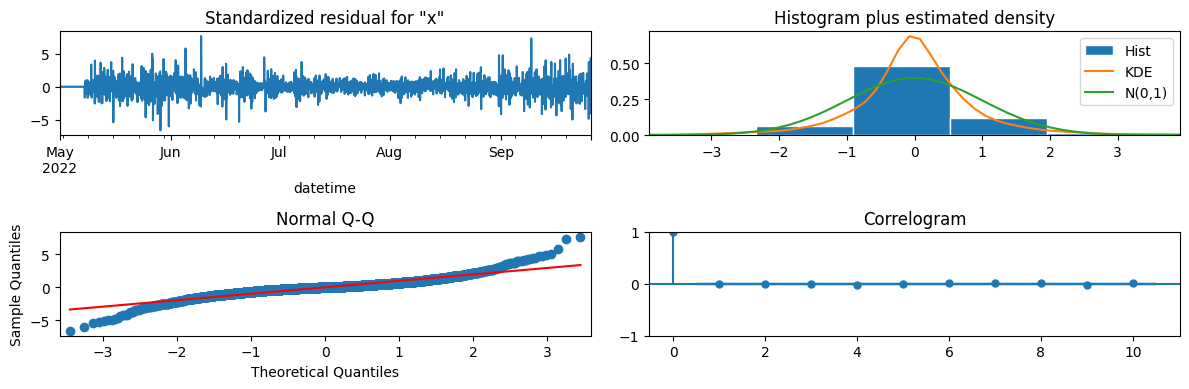

In [82]:
AR2_ct.plot_diagnostics()
plt.tight_layout()
plt.show()

## Point forecast and prediction interval
just a see its capability

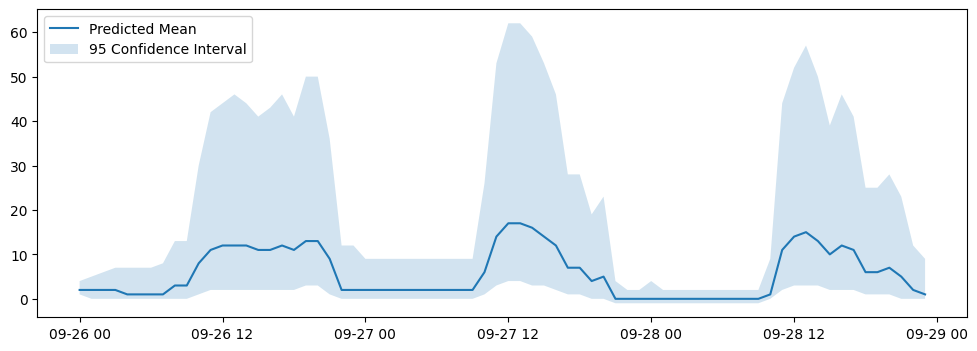

In [83]:
from scipy.special import inv_boxcox

h = 3 * 24

preds_arr = AR2_ct.get_forecast(h).predicted_mean \
    .add(cars.boxcox.tail(season).head(h).values) \
    .transform(lambda x: inv_boxcox(x, lmbda)) \
    .transform(lambda x: x - 1) \
    .transform(round)

conf_int_df = AR2_ct.get_forecast(h).conf_int() \
    .add(cars.boxcox.tail(season).head(h).values.reshape(-1, 1)) \
    .transform(lambda x: inv_boxcox(x, lmbda)) \
    .transform(lambda x: x - 1) \
    .transform(round)


def plot_forecast(y: pd.Series, conf_int: pd.DataFrame | None = None, gt: pd.Series | None = None):
    # plt.figure(figsize=(12, 6))
    plt.plot(y.index, y, label="Predicted Mean")
    if conf_int is not None:
        plt.fill_between(y.index, conf_int["lower x"], conf_int["upper x"], alpha=0.2, label="95 Confidence Interval")
    if gt is not None:
         plt.plot(gt, gt, label="Ground truth", color="orange")
    plt.legend()
    plt.show()

plot_forecast(preds_arr, conf_int_df)

# Modeling with Exponential Smoothing
Next, we model the time series within ETS (Error, Trend, Seasonal) 
threoretical framework. 
It is challeging because the timeseries frequency is hourly, and the 
seasonal period is weekly, leading to a large number of parameters to optimize
and to a potentially unstable optimization routine. 

A tipical solution for the large number seasonal parameters is to first 
remove the seasonal component from the original timeseries with a seasonal 
decomposition method, then fit the ETS model.

The forecast is then obtained as the sum of the deterministc seasonal component
and the prediction yielded the ETS.

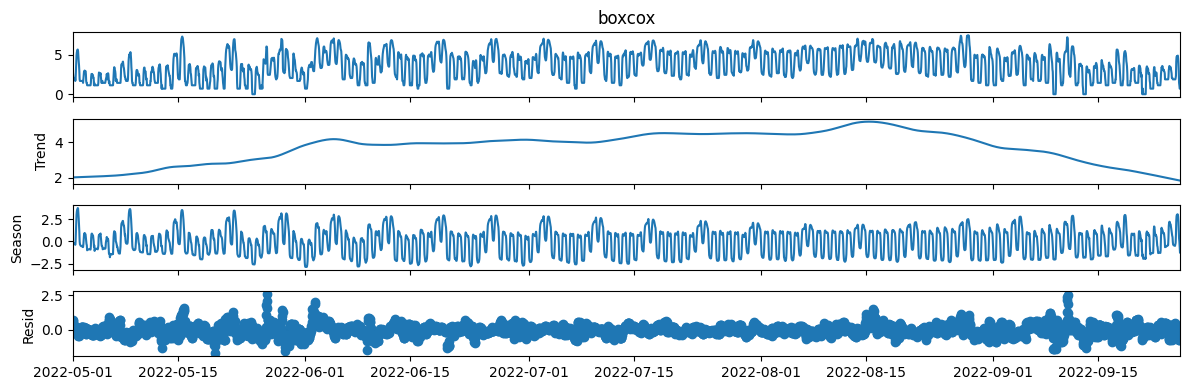

In [84]:
stl = tsa.STL(cars['boxcox'], period=24 * 7, robust=False).fit()
stl.plot()
plt.show()

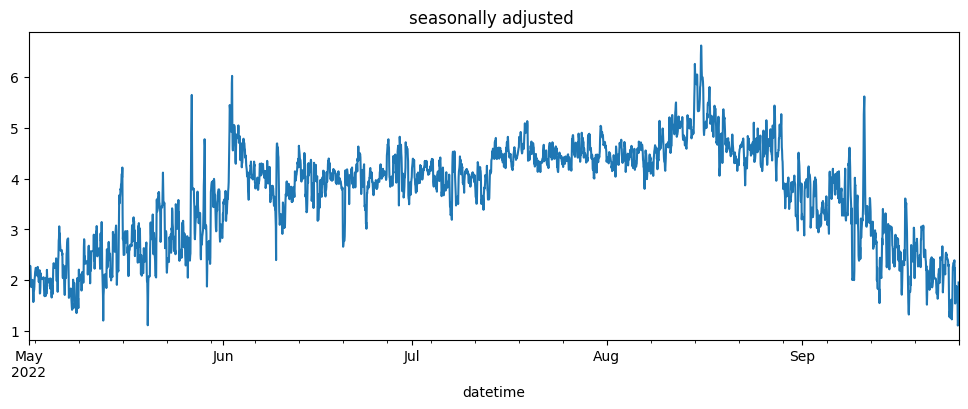

In [85]:
plt.title("seasonally adjusted ")
cars['s_adj'] = (cars['boxcox'] - stl.seasonal)
cars['s_adj'].plot()
plt.show()

In [86]:
ses_a = tsa.ETSModel(cars.s_adj, error='add', trend=None).fit(disp=False)
ses_m = tsa.ETSModel(cars.s_adj, error='mul', trend=None).fit(disp=False)
holt_aa = tsa.ETSModel(cars.s_adj, error='add', trend='add').fit(disp=False)
holt_ma = tsa.ETSModel(cars.s_adj, error='mul', trend='add').fit(disp=False)
holt_am = tsa.ETSModel(cars.s_adj, error='add', trend='mul').fit(disp=False)
holt_mm = tsa.ETSModel(cars.s_adj, error='mul', trend='mul').fit(disp=False)
damped_aa = tsa.ETSModel(cars.s_adj, error='add', trend='add', damped_trend=True).fit(disp=False)
damped_ma = tsa.ETSModel(cars.s_adj, error='mul', trend='add', damped_trend=True).fit(disp=False)
damped_am = tsa.ETSModel(cars.s_adj, error='add', trend='mul', damped_trend=True).fit(disp=False)
damped_mm = tsa.ETSModel(cars.s_adj, error='mul', trend='mul', damped_trend=True).fit(disp=False)

ets_model_ls = [
    ("ses_a", ses_a),
    ("ses_m", ses_m),
    ("holt_aa", holt_aa),
    ("holt_ma", holt_ma),
    ("holt_am", holt_am),
    ("holt_mm", holt_mm),
    ("damped_aa", damped_aa),
    ("damped_ma", damped_ma),
    ("damped_am", damped_am),
    ("damped_mm", damped_mm),
]

In [87]:
best_aic_model_idx = pd.Series(m.aic for _, m in ets_model_ls).idxmin()
best_bic_model_idx = pd.Series(m.bic for _, m in ets_model_ls).idxmin()
print(f'best model {ets_model_ls[best_aic_model_idx][0]}, AIC: {ets_model_ls[best_aic_model_idx][1].aic:.2f}')
print(f'best model {ets_model_ls[best_bic_model_idx][0]}, BIC: {ets_model_ls[best_bic_model_idx][1].bic:.2f}')

best model ses_a, AIC: -2029.01
best model ses_a, BIC: -2010.48


A simple exponential model with additive error is an ARMA(0, 1, 1) 
[ref](https://people.duke.edu/%7Ernau/411arim.htm). 

Indeed, simulating such ARMA processes shows a wide variaty of possible paths. 
Such plethora of future trajectories will be caputured by the prediction intervals.


<!-- $$\begin{split}
% (1 - L)y_t & = (1 + \theta_i L)w_t \\
y_t & = y_{t-1} + w_t + \theta_i w_{t-1} \\
\end{split}$$
$$ \begin{split}
s_0 & = x_0 \\
s_t & = \alpha x_t + (1 - \alpha) s_{t-1}  \\ 
\end{split}$$ -->

## how to forecast with a seasonally adjusted component?
<!-- $\hat{y}_{T+h|T} = y_{T + h - m(k+1)}$ last seen value in the seasonal period
where $m$ is seasonal period $k = \left \lfloor \frac{h -1}{m} \right \rfloor $ -->
$$\hat{y}_{T+h|T} = y_{T + h - m} + ets(T+h) \quad h \leq m$$
where 
* ets(T+h) is a forecast resulting form that method
* $y_{T + h - m}$ is a naive seasonal forecasting method where the prediction
is equal to the last seen season

The package `statsmodels` only offers the ETS forecast, while the naive forecast
must be implemented. 
Even the prediction interval are to be computed from the simulate method. 
Now I understand the need for a better forecasting package.
[implementation](https://stackoverflow.com/questions/70277316/how-to-take-confidence-interval-of-statsmodels-tsa-holtwinters-exponentialsmooth)

If I were to rewrite this project, I would use the nixtala package where
this features is already implemented.

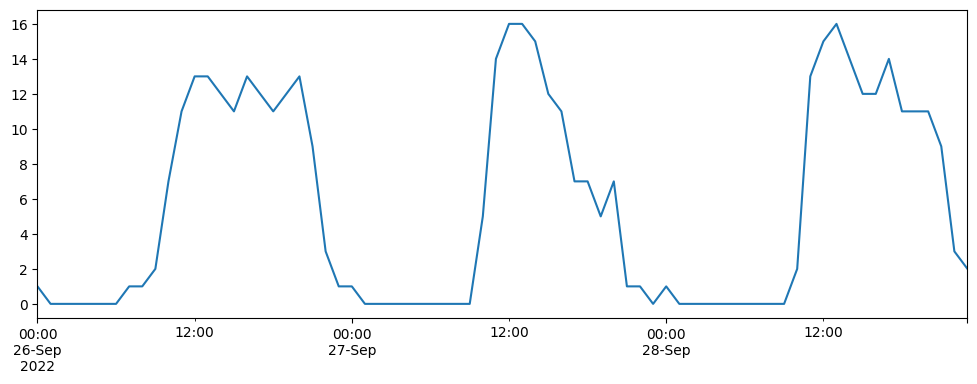

In [88]:
# point forecasts
# a simple proof of concept
h = 24 * 3

preds = (ses_a.forecast(h) + stl.seasonal.tail(season).head(h).values) \
    .transform(lambda x: inv_boxcox(x, lmbda)) \
    .transform(lambda x: x - 1) \
    .transform(round)

preds.plot()
plt.show()

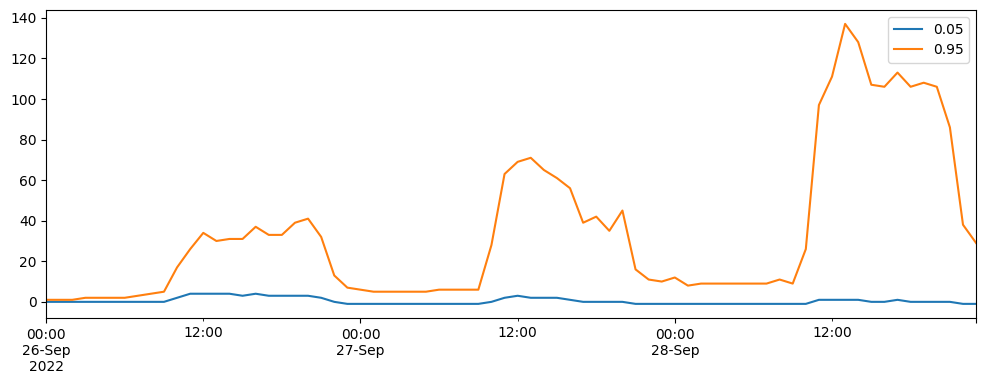

In [89]:
### prediction intervals
from statsmodels.tsa.exponential_smoothing.ets import ETSResults
def compute_pred_interval(ets_model: ETSResults, h: int, alpha:float = 0.05, n_sim: int = 500):
    assert h > 0
    assert alpha > 0 and alpha < 1 
    sim_df = ets_model.simulate(nsimulations=h, repetitions=n_sim, anchor='end')
    upper_level = 1 - alpha
    lower_level = alpha
    upper_ts = sim_df.quantile(upper_level, axis=1)
    lower_ts = sim_df.quantile(lower_level, axis=1)
    pred_int_df = pd.concat([lower_ts, upper_ts], axis=1)
    return pred_int_df

# pred_int_df = compute_pred_interval(ses_a, h)
h = 3* 24
pred_int_df = compute_pred_interval(ses_a, h, alpha=0.05) \
    .add(stl.seasonal.tail(season).head(h).values.reshape(-1, 1)) \
    .transform(lambda x: inv_boxcox(x, lmbda)) \
    .transform(lambda x: x - 1) \
    .transform(round)
pred_int_df.plot()
plt.show()


# Models selection and evaluation
In order to choose the best model, we are going to:
1. randomly select N instants of the time series
2. train each model from instant 0 to the selected istant. 
3. forecast h samples 
4. compute root mean squared error and mean absolute error

the choice of the random selection of instants is get a better approximation
of the generalization error. 

In [90]:
from collections.abc import Callable
from pprint import pprint

# compute point and prediction interval forecasts
# AR(2) + deterministic trend
def sar2_forecast(z: pd.Series, h: int, alpha:float):
    season = 24 * 7
    x = z - z.shift(periods=season)
    model = tsa.SARIMAX(x, order=(2, 0, 0), trend='ct').fit(disp=False)
    if model.mle_retvals['converged'] == False:
        pprint(model.mle_retvals)
    mean = model.get_forecast(h).predicted_mean \
        .add(z.tail(season).head(h).values)
    pred_int_df = model.get_forecast(h).conf_int(alpha) \
        .add(z.tail(season).head(h).values.reshape(-1, 1))
    preds = pd.concat([mean, pred_int_df], axis=1)
    return preds

# compute point and prediction interval forecasts
# seasonal ets
def s_ets_forecast(z: pd.Series, h: int, alpha: float):
    season = 24 * 7
    stl = tsa.STL(z,period=season, robust=False).fit() # seasonal decomposition
    s_adj = z - stl.seasonal # seaonally adjusted
    model = tsa.ETSModel(s_adj, error="add", trend=None).fit(disp=False)
    if model.mle_retvals['converged'] == False:
        pprint(model.mle_retvals)
    mean = model.forecast(h)
    sim_df = model.simulate(nsimulations=h, repetitions=500, anchor='end')
    upper_ts = sim_df.quantile(1 - alpha / 2, axis=1)
    lower_ts = sim_df.quantile(alpha / 2, axis=1)
    preds = pd.concat([mean, lower_ts, upper_ts], axis=1) \
        .add(stl.seasonal.tail(season).head(h).values.reshape(-1, 1))
    return preds

In [91]:
import numpy as np
def evaluate_forecast_model(
    forecast_model: Callable[[pd.Series, int, float], pd.DataFrame],
    timeseries: pd.Series,
    horizon: int = 24,
    alpha: float = 0.2,
    seed: int = 100,
    split_n: int = 2,
    start_idx: int = 24 * 7,
):
    assert alpha > 0 and alpha < 0.5
    result_ls = list()
    rng = np.random.default_rng(seed=seed)
    end_idx = len(timeseries) - horizon
    train_idx = rng.choice(np.arange(start_idx, end_idx), split_n, replace=False)
    for idx in np.sort(train_idx):
        train_sr = cars.cars.iloc[:idx]
        test_sr = cars.cars.iloc[idx : idx + horizon]
        _, lmbda = stats.boxcox(train_sr + 1)
        z = train_sr \
            .transform(lambda x: x + 1) \
            .transform(lambda x: stats.boxcox(x, lmbda))
        pred_df = forecast_model(z, horizon, alpha) \
            .transform(lambda x: inv_boxcox(x, lmbda)) \
            .transform(lambda x: x - 1) \
            .transform(round)

        mae = (test_sr - pred_df.iloc[:, 0]).abs().mean()
        rmse = (test_sr - pred_df.iloc[:, 0]) \
            .transform(lambda x: x**2).mean() ** (1 / 2)
        result_ls.append(
            {
                "model": forecast_model.__name__[:-9], # strip _forecast from the name
                "train_sr_len": idx,
                "alpha": alpha,
                "horizon": horizon,
                "mae": mae,
                "rmse": rmse,
                "predicted_mean": pred_df.iloc[:, 0],
                "lower": pred_df.iloc[:, 1],
                "upper": pred_df.iloc[:, 2],
            }
        )

    result_df = pd.DataFrame(result_ls)
    return result_df

In [92]:
HORIZON = 24 * 7
SPLIT_N = 20
ALPHA = 0.2
sar2_result_df = evaluate_forecast_model(sar2_forecast, cars.cars, horizon=HORIZON, split_n=SPLIT_N, alpha=ALPHA)
s_ets_result_df = evaluate_forecast_model(s_ets_forecast, cars.cars, horizon=HORIZON, split_n=SPLIT_N, alpha=ALPHA)

{'converged': False,
 'fcalls': 210,
 'fopt': np.float64(-0.3659368297781624),
 'gopt': array([-0.01227049,  0.20472823,  0.00122825,  0.00046261,  0.0230786 ]),
 'iterations': 1,
 'warnflag': 2}


/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to c

{'converged': False,
 'fcalls': 276,
 'fopt': np.float64(-0.36037216390908716),
 'gopt': array([2.79786995e-02, 1.54068086e+01, 8.70212175e-04, 3.14452125e-04,
       1.03746614e-02]),
 'iterations': 2,
 'warnflag': 2}
{'converged': False,
 'fcalls': 318,
 'fopt': np.float64(-0.3030865382670355),
 'gopt': array([ 2.69110625e-02,  2.08601884e+01,  3.47738183e-04, -3.40585793e-04,
        1.86711568e-03]),
 'iterations': 2,
 'warnflag': 2}
{'converged': False,
 'fcalls': 264,
 'fopt': np.float64(-0.08655936876869795),
 'gopt': array([9.84244930e-03, 2.00220633e+01, 1.05237558e-04, 4.19599269e-04,
       6.93115042e-03]),
 'iterations': 1,
 'warnflag': 2}
{'converged': False,
 'fcalls': 276,
 'fopt': np.float64(-0.027572828217589856),
 'gopt': array([ 1.16249695e-02,  3.38701899e+01, -7.30388167e-05, -2.45007414e-04,
        1.18769108e-03]),
 'iterations': 1,
 'warnflag': 2}


/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'converged': False,
 'fcalls': 294,
 'fopt': np.float64(0.05457765047315886),
 'gopt': array([ 1.15759824e-02,  5.56814162e+01, -9.31089511e-05, -3.58325114e-04,
       -3.09188995e-04]),
 'iterations': 1,
 'warnflag': 2}


/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'converged': False,
 'fcalls': 294,
 'fopt': np.float64(0.060501987154824986),
 'gopt': array([ 1.10611872e-02,  6.22336895e+01, -9.33121400e-05, -4.13568228e-04,
       -8.30499382e-04]),
 'iterations': 1,
 'warnflag': 2}


/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'converged': False,
 'fcalls': 330,
 'fopt': np.float64(0.11487757852972738),
 'gopt': array([ 8.87325475e-03,  9.33565057e+01, -5.93808586e-05, -3.03692338e-04,
       -7.16546171e-04]),
 'iterations': 1,
 'warnflag': 2}
{'converged': False,
 'fcalls': 330,
 'fopt': np.float64(0.11593254108556264),
 'gopt': array([ 8.77780581e-03,  9.53105855e+01, -6.00160838e-05, -3.08577892e-04,
       -7.55696350e-04]),
 'iterations': 1,
 'warnflag': 2}


/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'converged': False,
 'fcalls': 330,
 'fopt': np.float64(0.11888368303728644),
 'gopt': array([ 8.73945136e-03,  9.51590085e+01, -5.96977009e-05, -3.08640963e-04,
       -7.56661712e-04]),
 'iterations': 1,
 'warnflag': 2}


/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'converged': False,
 'fcalls': 312,
 'fopt': np.float64(0.16397244884234388),
 'gopt': array([ 7.71551767e-03,  1.13077527e+02, -5.29668115e-05, -3.26405075e-04,
       -1.02871195e-03]),
 'iterations': 1,
 'warnflag': 2}


/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'converged': False,
 'fcalls': 318,
 'fopt': np.float64(0.17009146843509076),
 'gopt': array([ 7.31941862e-03,  1.21476885e+02, -4.25592062e-05, -2.82005880e-04,
       -8.61379065e-04]),
 'iterations': 1,
 'warnflag': 2}


/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'converged': False,
 'fcalls': 312,
 'fopt': np.float64(0.2058407028846973),
 'gopt': array([ 6.22073847e-03,  1.25767418e+02, -2.98093716e-05, -1.63636654e-04,
       -2.87441720e-04]),
 'iterations': 1,
 'warnflag': 2}


/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'converged': False,
 'fcalls': 300,
 'fopt': np.float64(0.21513761603713336),
 'gopt': array([ 6.10887539e-03,  1.31555961e+02, -3.36653760e-05, -1.86846574e-04,
       -4.14600909e-04]),
 'iterations': 1,
 'warnflag': 2}


/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'converged': False,
 'fcalls': 300,
 'fopt': np.float64(0.23402696185787125),
 'gopt': array([ 5.98436600e-03,  1.39243605e+02, -5.11757053e-05, -2.36442740e-04,
       -5.94592647e-04]),
 'iterations': 1,
 'warnflag': 2}


/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'converged': False,
 'fcalls': 306,
 'fopt': np.float64(0.23066932167616064),
 'gopt': array([ 6.00743454e-03,  1.66916352e+02, -6.74295259e-05, -2.92638166e-04,
       -8.28811755e-04]),
 'iterations': 1,
 'warnflag': 2}


/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'converged': False,
 'fcalls': 306,
 'fopt': np.float64(0.22656620226858634),
 'gopt': array([ 5.85100044e-03,  1.73338590e+02, -6.30124813e-05, -2.75010731e-04,
       -7.63360156e-04]),
 'iterations': 1,
 'warnflag': 2}


/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'converged': False,
 'fcalls': 318,
 'fopt': np.float64(0.2498365156707942),
 'gopt': array([ 5.56334550e-03,  1.72472996e+02, -6.34376107e-05, -2.64127395e-04,
       -6.87349180e-04]),
 'iterations': 1,
 'warnflag': 2}


/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'converged': False,
 'fcalls': 336,
 'fopt': np.float64(0.24961379442372186),
 'gopt': array([ 5.65902481e-03,  1.82008878e+02, -6.94170860e-05, -2.85882273e-04,
       -7.70103273e-04]),
 'iterations': 1,
 'warnflag': 2}


Each time the optmization routine does not converge, the warning flag is two, 
which means that it did not converge because the
_gradient and/or function calls are not changing_ 
[ref](https://github.com/statsmodels/statsmodels/blob/main/statsmodels/base/model.py#L1290) 
even though an objective function local minimum has not been reached. 
This may be due to the combination of the machine precision and the L-BFGS algorithm
precision. It requires further investigation.

In [93]:
import matplotlib.dates
def plot_forecast(
    ax: plt.Axes,
    timeseries: pd.Series,
    model: str,
    train_sr_len: int,
    alpha: float,
    horizon: int,
    mae: float,
    rmse: float,
    predicted_mean: pd.Series,
    lower: pd.Series,
    upper: pd.Series,
):
    ax.plot(timeseries.iloc[train_sr_len: train_sr_len + horizon], label="cars")
    ax.plot(predicted_mean, label="predicted mean")
    ax.fill_between(
        predicted_mean.index,
        lower,
        upper,
        label=f"{(1 - alpha)*100:.0f}% prediction interval",
        alpha=0.3,
    )
    ax.set_ylim(bottom = -1, top=600)
    ax.set_title(f"{model} mae {mae:.0f} rmse {rmse:.0f} training samples {train_sr_len}")
    ax.grid()
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m-%d'))
    return ax


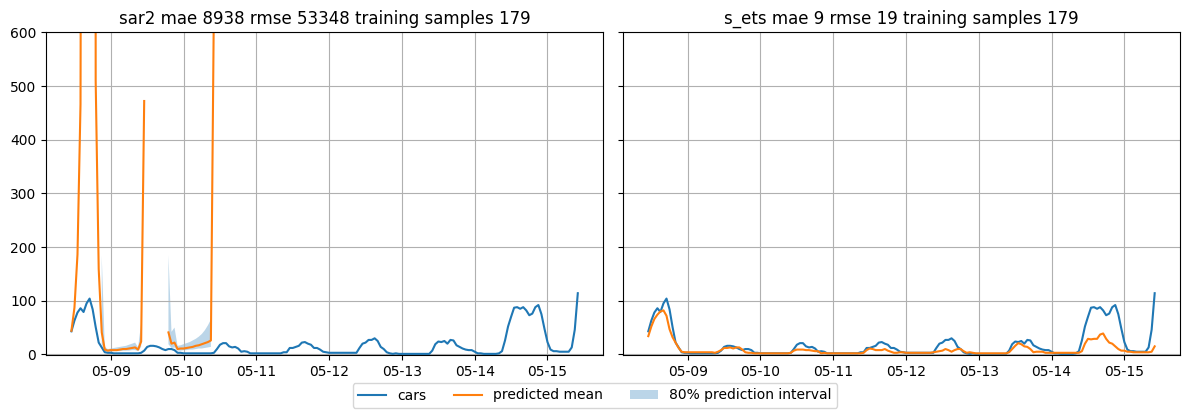

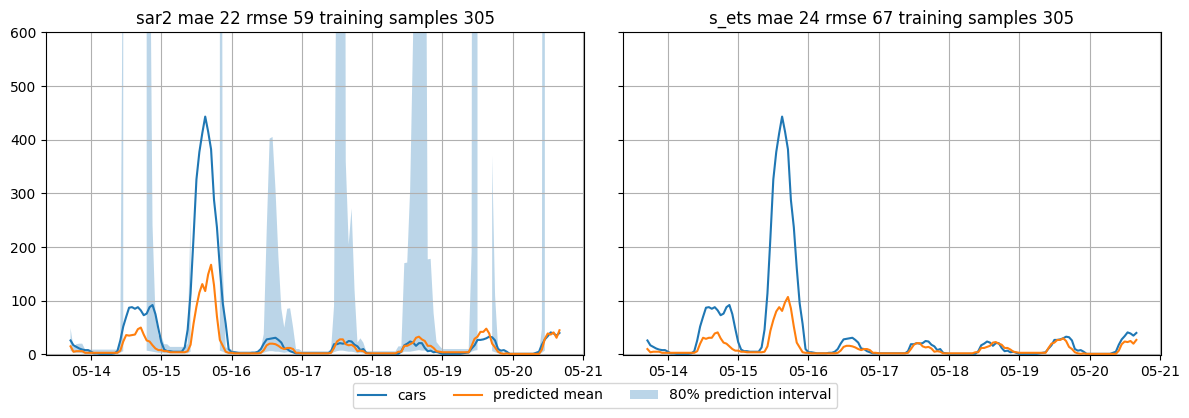

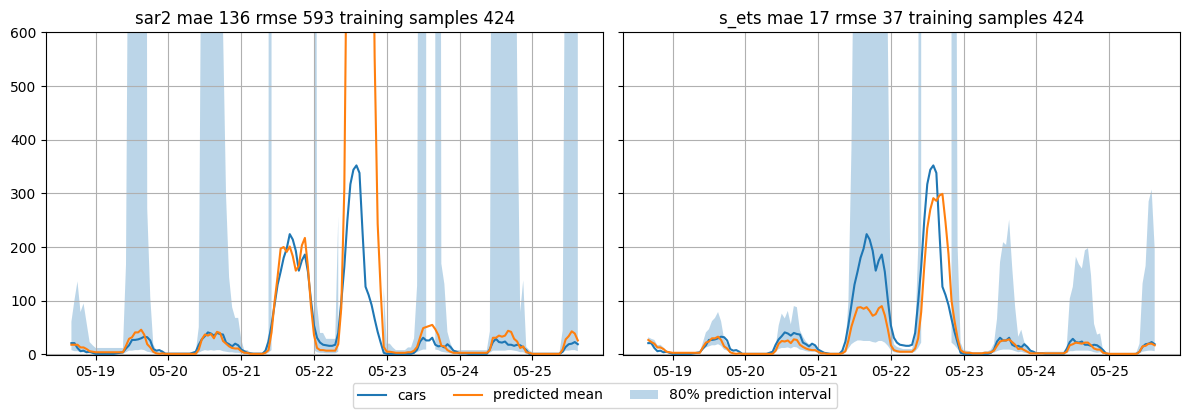

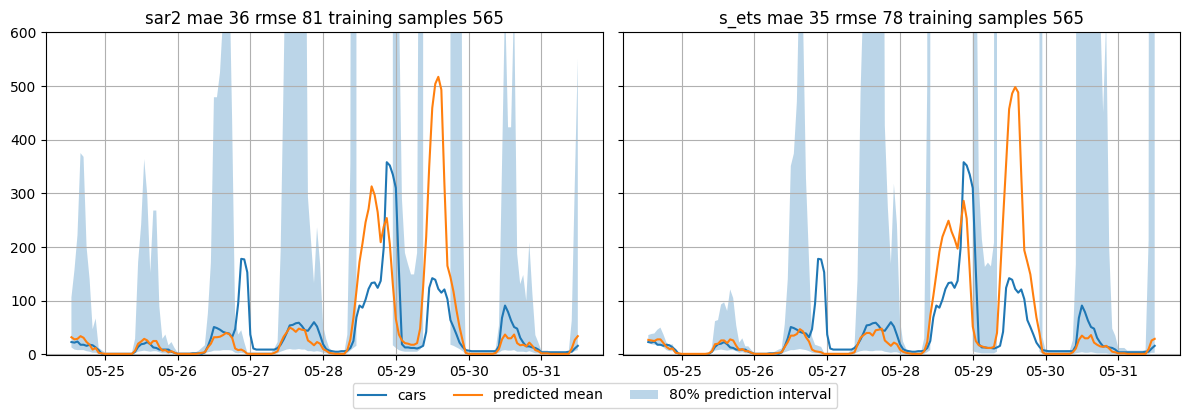

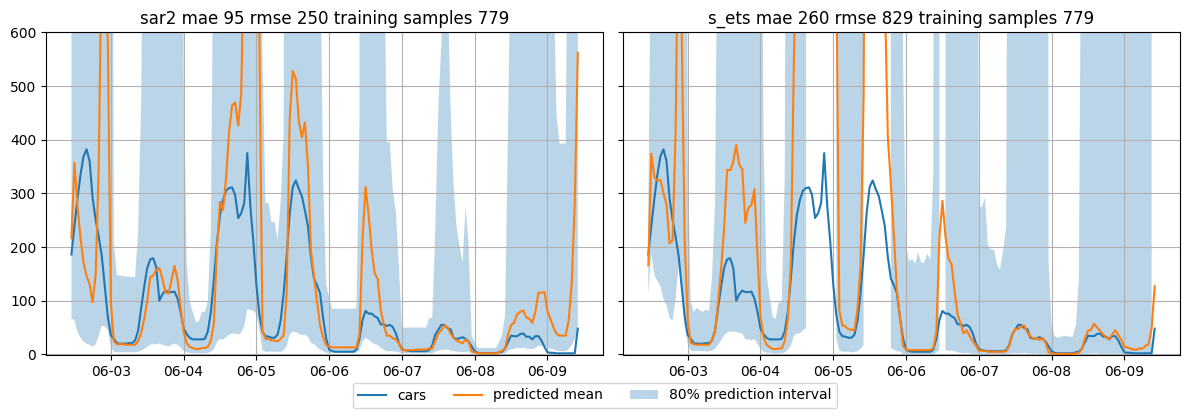

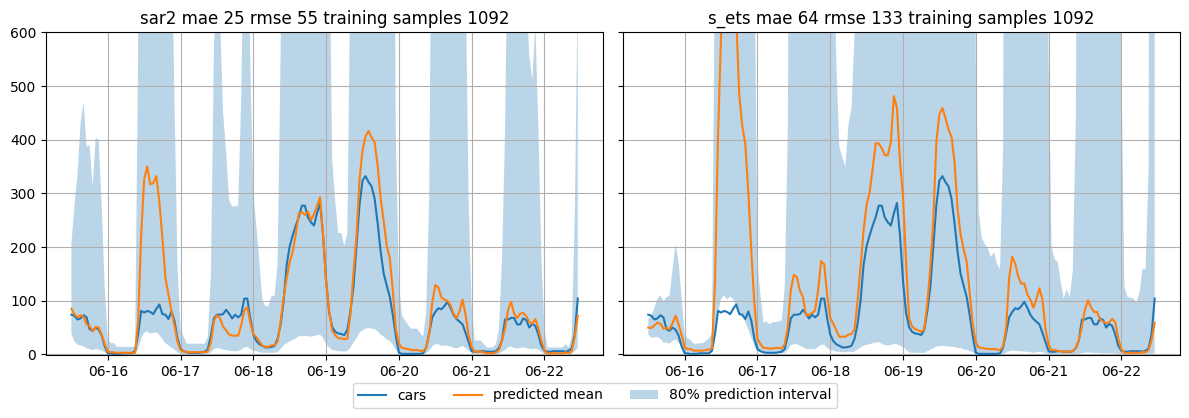

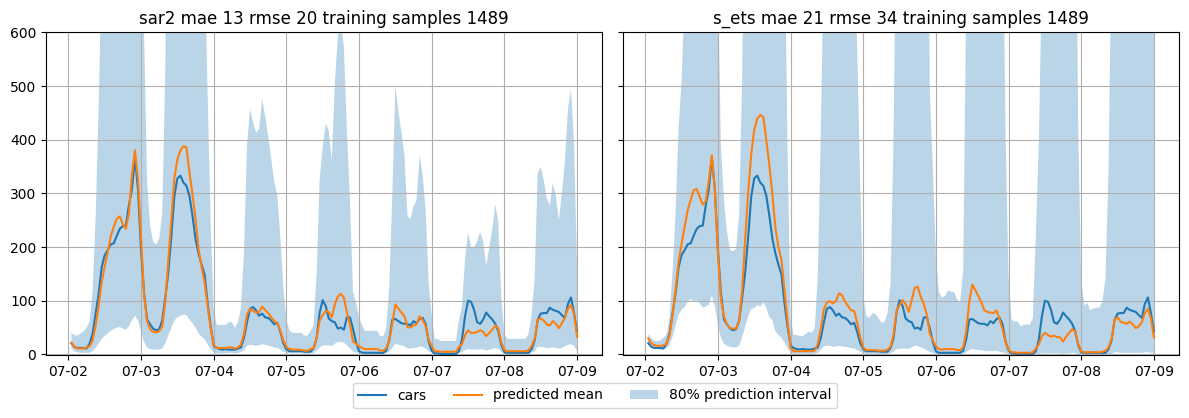

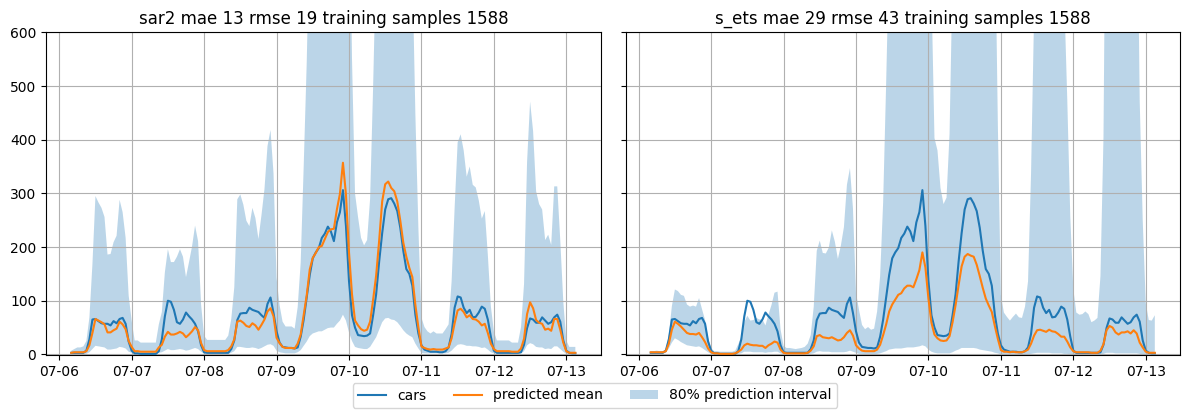

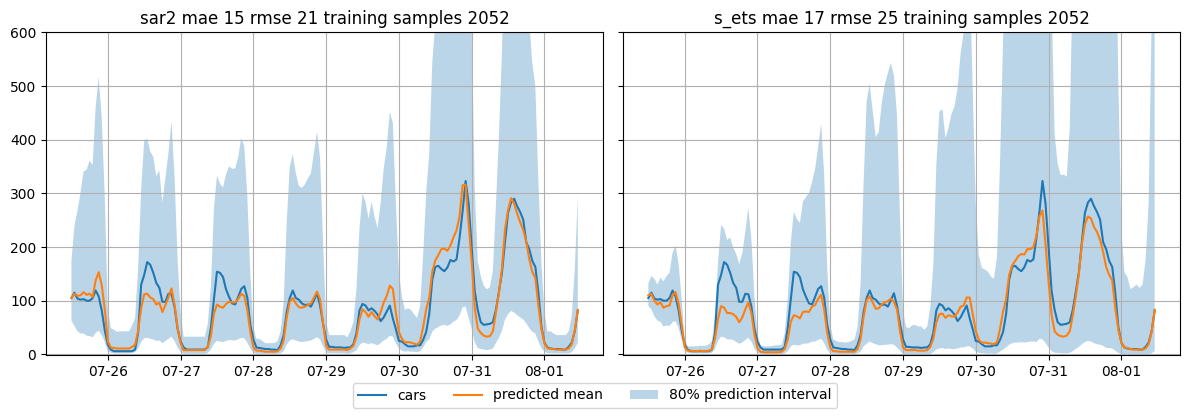

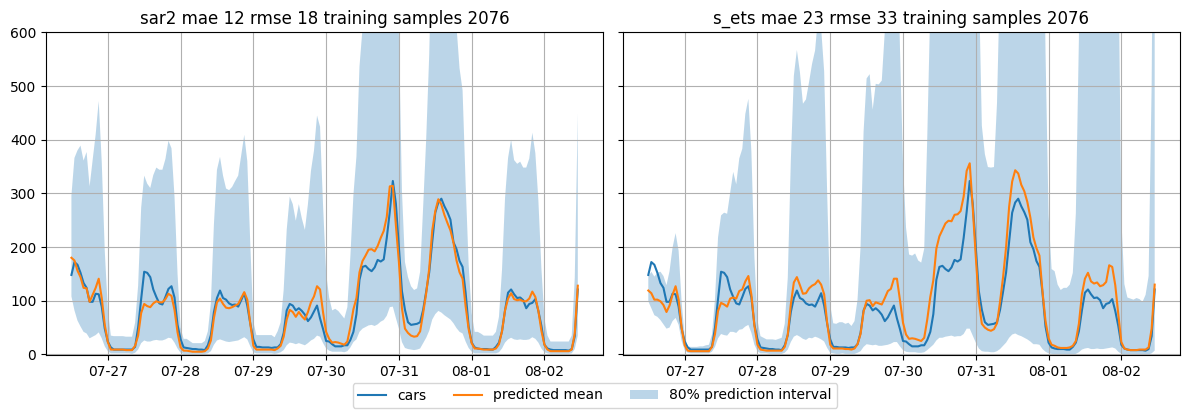

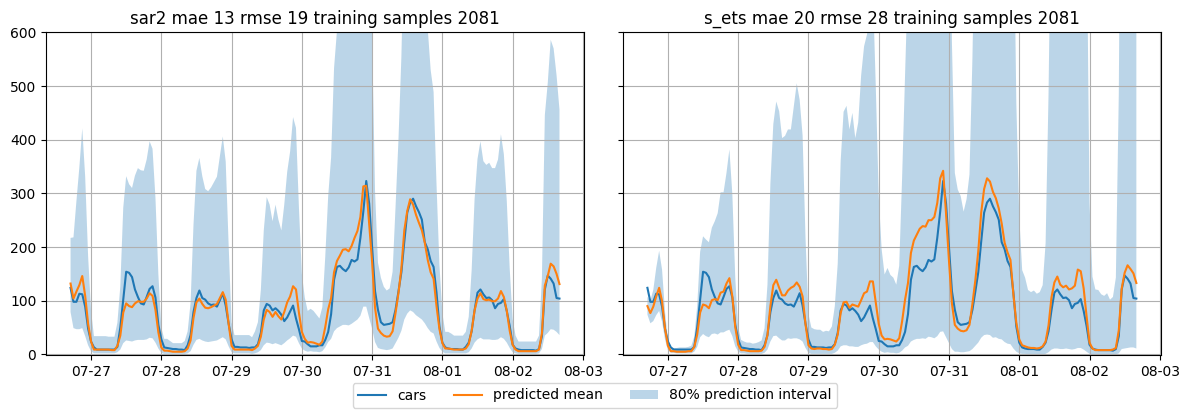

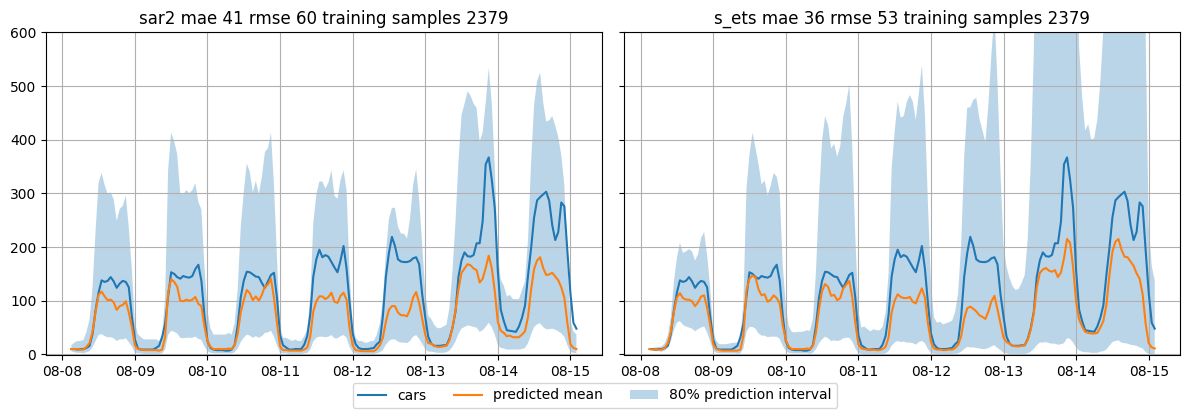

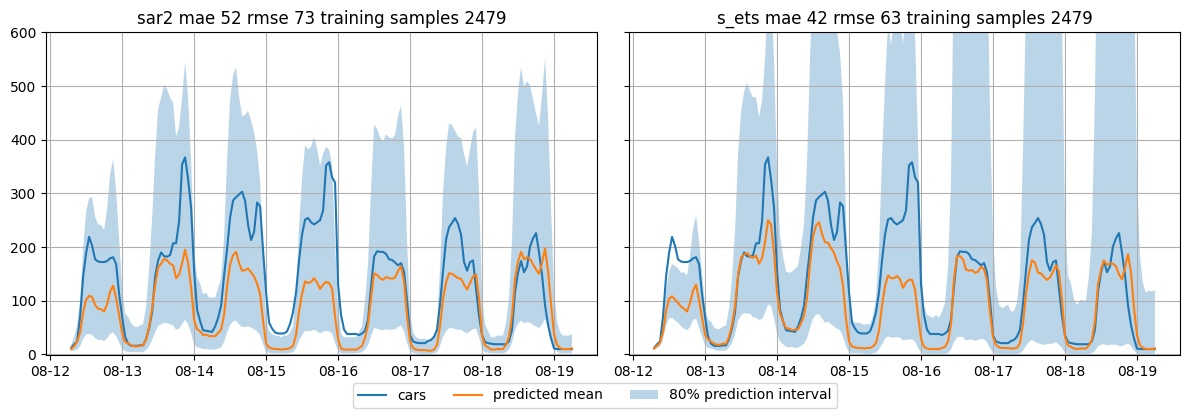

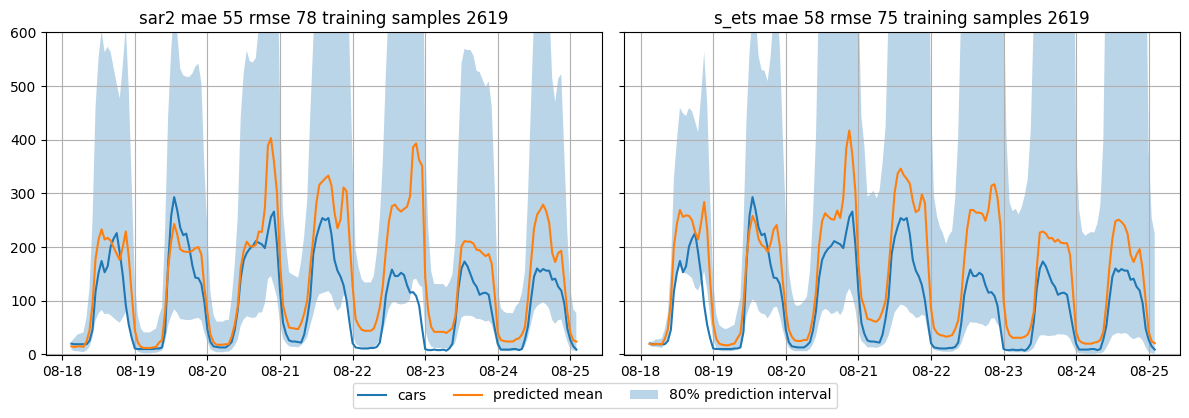

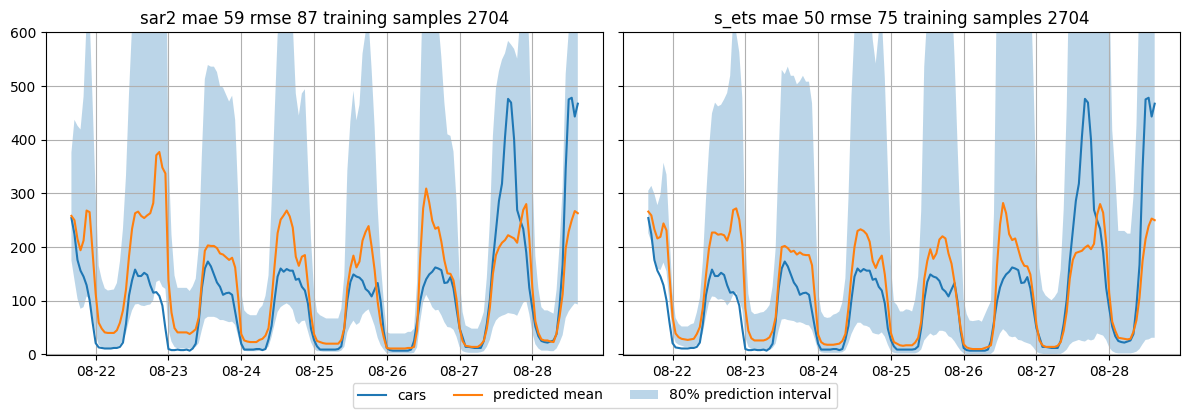

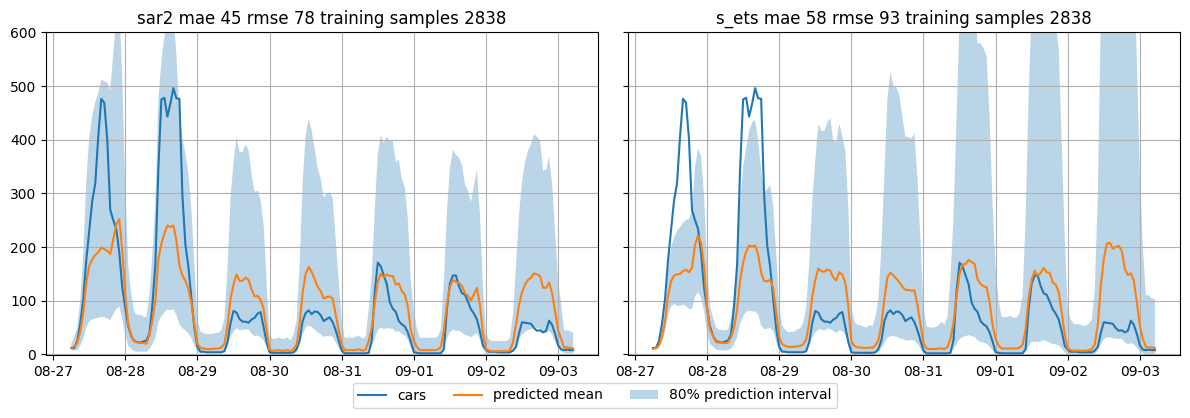

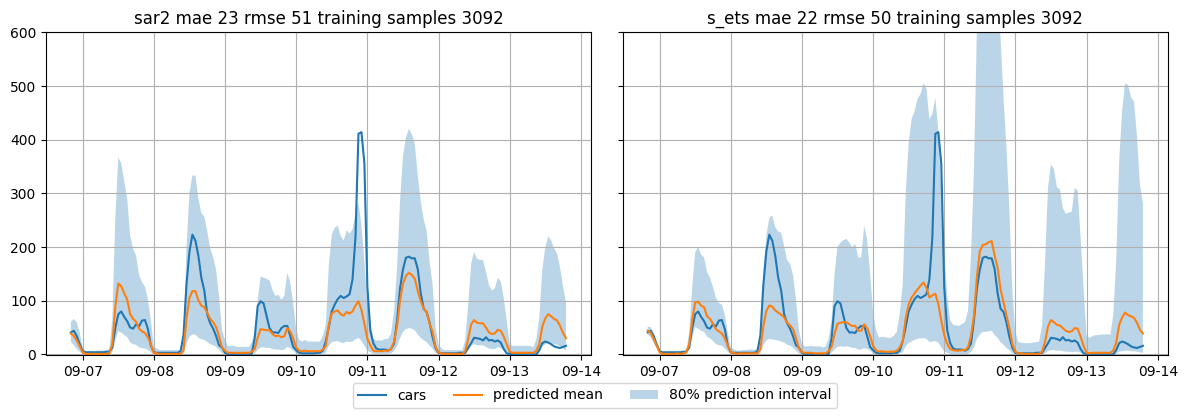

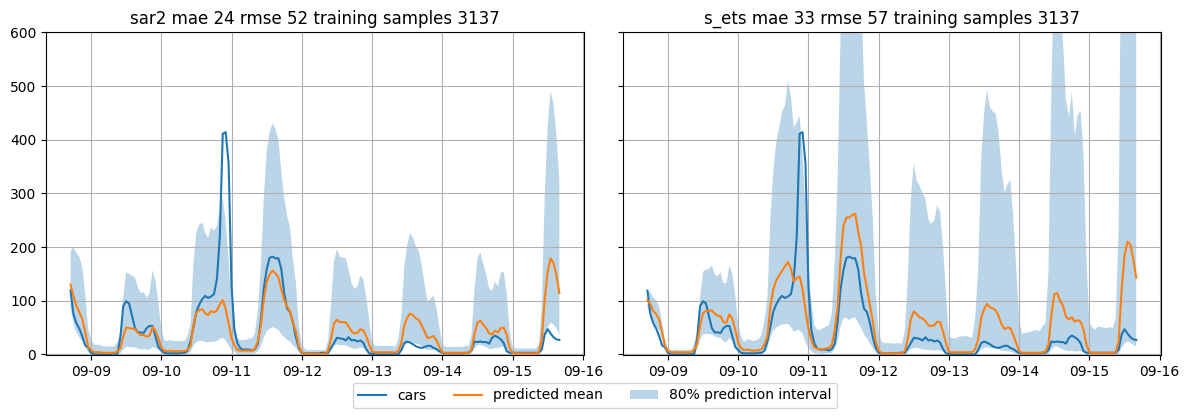

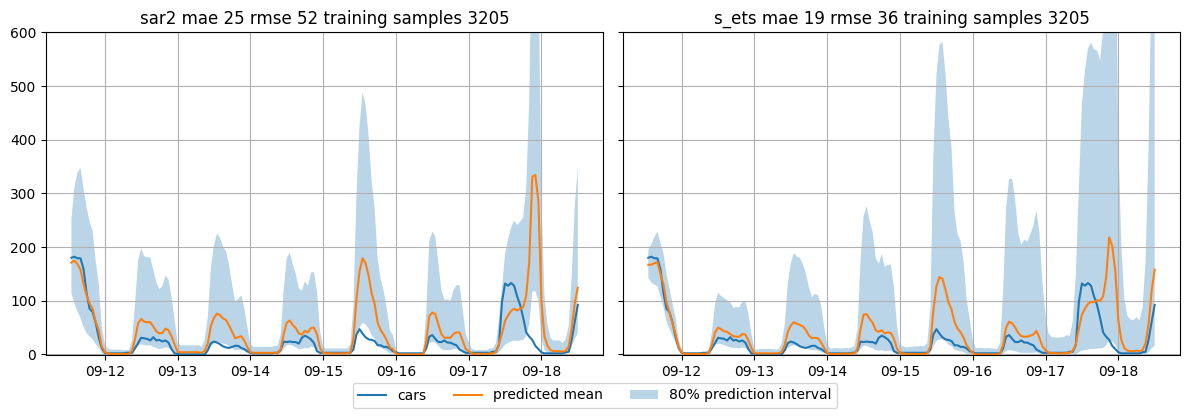

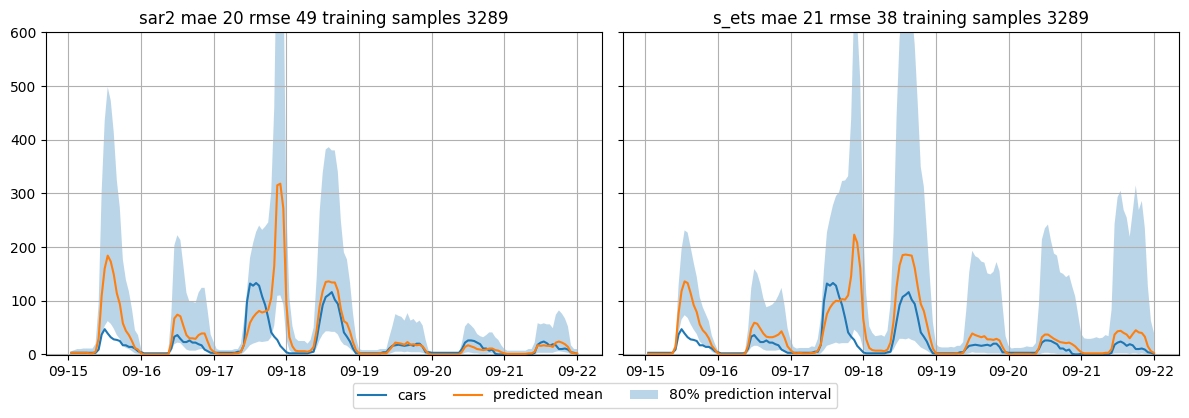

In [94]:
nrows = len(sar2_result_df)
for i in range(nrows):
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 4))
    plot_forecast(ax[0], cars.cars, **sar2_result_df.iloc[i])
    plot_forecast(ax[1], cars.cars, **s_ets_result_df.iloc[i])
    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)  # Make room for the legend
    plt.show()


In [95]:
pd.concat([sar2_result_df, s_ets_result_df]) \
    .drop(columns=["predicted_mean", "lower", "upper"]) \
    .sort_values(by=["mae", "rmse"]) \
    .iloc[:10]

,model,train_sr_len,alpha,horizon,mae,rmse
0,s_ets,179,0.2,168,9.000000,18.739759
9,sar2,2076,0.2,168,12.285714,18.137044
10,sar2,2081,0.2,168,12.880952,18.759759
6,sar2,1489,0.2,168,12.952381,19.693485
7,sar2,1588,0.2,168,13.047619,19.047872
8,sar2,2052,0.2,168,14.553571,21.138855
8,s_ets,2052,0.2,168,16.869048,25.475245
2,s_ets,424,0.2,168,17.214286,36.574939
18,s_ets,3205,0.2,168,19.208333,35.850301
10,s_ets,2081,0.2,168,19.553571,28.361086


Now that we have the full picture, we compare the models.
* when there un unpredicted spike, both models predict a spike the following
week (ref. May 15 -> May 22, Aug 16 -> Aug 23, Sept 11 -> Sept 19)

* ETS
    * PROs:
        * better at predicting with fewer samples. with only 179 training samples, it yields
    a mean absolute error of only nine. 
    * CONs: 
        * the quantile forecasts minimum and maximum values increases with as the distance
    from the last training sample. 

* AR(2)
    * PROs:
        * the quantile forecasts is mostly stable even when the horizon distance
        increases
    * CONs:
        * worse at predicting with fewer samples than the the other model

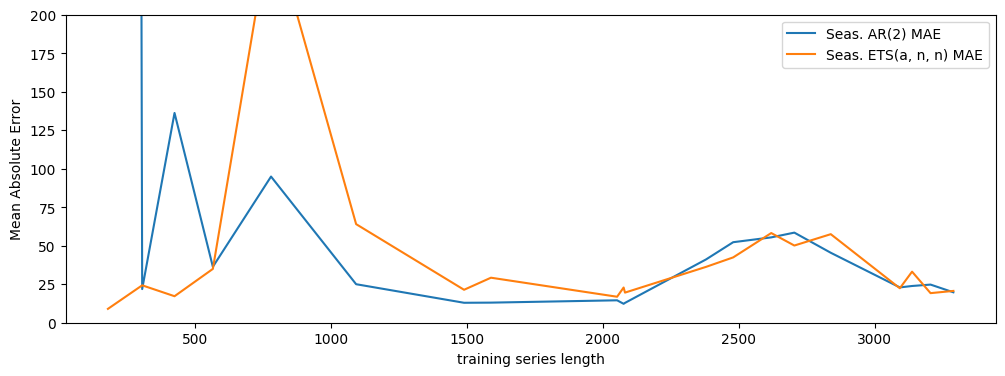

In [96]:
plt.plot(sar2_result_df["train_sr_len"], sar2_result_df["mae"], label="Seas. AR(2) MAE")
plt.plot(s_ets_result_df["train_sr_len"], s_ets_result_df["mae"], label="Seas. ETS(a, n, n) MAE")
# plt.plot(sar2_result_df["train_sr_len"], sar2_result_df["rmse"], label="Seas. AR(2) MAE", color="tab:blue", linestyle="--")
# plt.plot(s_ets_result_df["train_sr_len"], s_ets_result_df["rmse"], label="Seas. ETS(a, n, n) MAE", color="orange", linestyle="--")
# pd.concat([sar2_result_df, s_ets_result_df]).groupby("model").plot(x="train_sr_len", y="mae", legend="")
plt.ylabel("Mean Absolute Error")
plt.xlabel("training series length")
plt.ylim(bottom=0, top=200)
plt.legend()
plt.show()


Only the mean absolute error is plotted because the RMSE is highly correlated and
the mae is simpler to interpret.

The spikes we see in the MAE - training size plot correlates with the periods
of higher variances. 

To have the best of both models, we can select the seasonal ETS for month, 
then switch to the autoregressive for the remaining time.

In [97]:
def model_ensable_forecast(z: pd.Series, h: int, alpha: float):
    threshold = 24 * 7 * 4
    if len(z) > threshold:
        return sar2_forecast(z, h, alpha)
    else:
        return s_ets_forecast(z, h, alpha)

res_df = evaluate_forecast_model(model_ensable_forecast, cars.cars, horizon=HORIZON, split_n=SPLIT_N, alpha=ALPHA)

/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'converged': False,
 'fcalls': 264,
 'fopt': np.float64(-0.08655936876869795),
 'gopt': array([9.84244930e-03, 2.00220633e+01, 1.05237558e-04, 4.19599269e-04,
       6.93115042e-03]),
 'iterations': 1,
 'warnflag': 2}
{'converged': False,
 'fcalls': 276,
 'fopt': np.float64(-0.027572828217589856),
 'gopt': array([ 1.16249695e-02,  3.38701899e+01, -7.30388167e-05, -2.45007414e-04,
        1.18769108e-03]),
 'iterations': 1,
 'warnflag': 2}


/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'converged': False,
 'fcalls': 294,
 'fopt': np.float64(0.05457765047315886),
 'gopt': array([ 1.15759824e-02,  5.56814162e+01, -9.31089511e-05, -3.58325114e-04,
       -3.09188995e-04]),
 'iterations': 1,
 'warnflag': 2}


/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'converged': False,
 'fcalls': 294,
 'fopt': np.float64(0.060501987154824986),
 'gopt': array([ 1.10611872e-02,  6.22336895e+01, -9.33121400e-05, -4.13568228e-04,
       -8.30499382e-04]),
 'iterations': 1,
 'warnflag': 2}


/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'converged': False,
 'fcalls': 330,
 'fopt': np.float64(0.11487757852972738),
 'gopt': array([ 8.87325475e-03,  9.33565057e+01, -5.93808586e-05, -3.03692338e-04,
       -7.16546171e-04]),
 'iterations': 1,
 'warnflag': 2}


/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'converged': False,
 'fcalls': 330,
 'fopt': np.float64(0.11593254108556264),
 'gopt': array([ 8.77780581e-03,  9.53105855e+01, -6.00160838e-05, -3.08577892e-04,
       -7.55696350e-04]),
 'iterations': 1,
 'warnflag': 2}


/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'converged': False,
 'fcalls': 330,
 'fopt': np.float64(0.11888368303728644),
 'gopt': array([ 8.73945136e-03,  9.51590085e+01, -5.96977009e-05, -3.08640963e-04,
       -7.56661712e-04]),
 'iterations': 1,
 'warnflag': 2}


/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'converged': False,
 'fcalls': 312,
 'fopt': np.float64(0.16397244884234388),
 'gopt': array([ 7.71551767e-03,  1.13077527e+02, -5.29668115e-05, -3.26405075e-04,
       -1.02871195e-03]),
 'iterations': 1,
 'warnflag': 2}


/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'converged': False,
 'fcalls': 318,
 'fopt': np.float64(0.17009146843509076),
 'gopt': array([ 7.31941862e-03,  1.21476885e+02, -4.25592062e-05, -2.82005880e-04,
       -8.61379065e-04]),
 'iterations': 1,
 'warnflag': 2}


/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'converged': False,
 'fcalls': 312,
 'fopt': np.float64(0.2058407028846973),
 'gopt': array([ 6.22073847e-03,  1.25767418e+02, -2.98093716e-05, -1.63636654e-04,
       -2.87441720e-04]),
 'iterations': 1,
 'warnflag': 2}


/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'converged': False,
 'fcalls': 300,
 'fopt': np.float64(0.21513761603713336),
 'gopt': array([ 6.10887539e-03,  1.31555961e+02, -3.36653760e-05, -1.86846574e-04,
       -4.14600909e-04]),
 'iterations': 1,
 'warnflag': 2}


/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'converged': False,
 'fcalls': 300,
 'fopt': np.float64(0.23402696185787125),
 'gopt': array([ 5.98436600e-03,  1.39243605e+02, -5.11757053e-05, -2.36442740e-04,
       -5.94592647e-04]),
 'iterations': 1,
 'warnflag': 2}


/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'converged': False,
 'fcalls': 306,
 'fopt': np.float64(0.23066932167616064),
 'gopt': array([ 6.00743454e-03,  1.66916352e+02, -6.74295259e-05, -2.92638166e-04,
       -8.28811755e-04]),
 'iterations': 1,
 'warnflag': 2}


/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'converged': False,
 'fcalls': 306,
 'fopt': np.float64(0.22656620226858634),
 'gopt': array([ 5.85100044e-03,  1.73338590e+02, -6.30124813e-05, -2.75010731e-04,
       -7.63360156e-04]),
 'iterations': 1,
 'warnflag': 2}


/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'converged': False,
 'fcalls': 318,
 'fopt': np.float64(0.2498365156707942),
 'gopt': array([ 5.56334550e-03,  1.72472996e+02, -6.34376107e-05, -2.64127395e-04,
       -6.87349180e-04]),
 'iterations': 1,
 'warnflag': 2}
{'converged': False,
 'fcalls': 336,
 'fopt': np.float64(0.24961379442372186),
 'gopt': array([ 5.65902481e-03,  1.82008878e+02, -6.94170860e-05, -2.85882273e-04,
       -7.70103273e-04]),
 'iterations': 1,
 'warnflag': 2}


/Users/giuliozabotto/Documents/garage-demand-forecasts/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


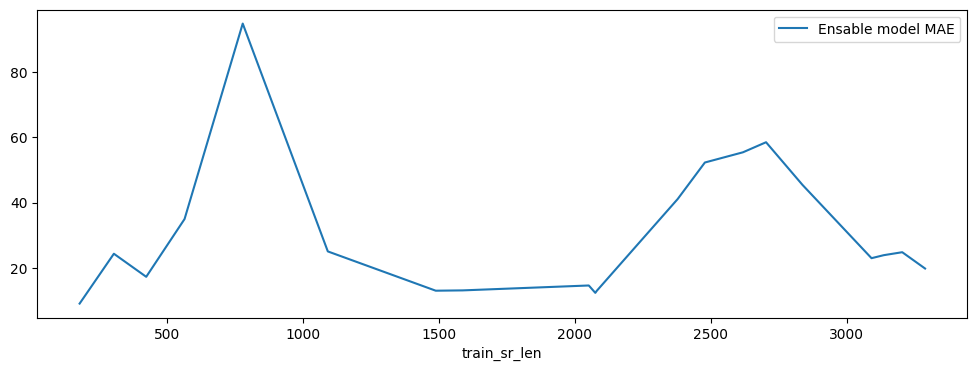

In [98]:
pd.concat([res_df]) \
    .plot(x="train_sr_len", y="mae", label="Ensable model MAE")
    # .iloc[:10]
plt.show()

# final considerations and future developments
* The ensable model can be used in production because the mean absolute error of
the point forecasts is whithin 20 to 50 cars which is a reasonable error to schedule
the employee shifts.
* The main drawbacks is that it is not robust: an extreme value in the previous 
week heavily entails a spike in the predicted mean of the same day.
* From the modeling perspective, GARCH models may overcome the problem of the 
heteroschedasticity of our timeseries. 
* From the analysis perspective, a more systematic approach to evaluate the quantile
predictions is computing the _Continuous Ranked Probability Score_ [ref](https://doi.org/10.1146/annurev-statistics-062713-085831)

# Bibliography
* Rob J Hyndman and George Athanasopoulos, _Forecasting: Principles and Practice (3rd ed)_, https://otexts.com/fpp3/
* Robert B. Cleveland,' William S. Cleveland, Jean E. McRae, and Irma Terpenning, _STL: A Seasonal-Trend Decomposition Procedure Based on Loess_, Journal of Official Statistics, Vol. 6. No. 1. 1990. pp. 3-73
* Box, G.E.P. and G.M. Jenkins (1976). _Time Series Analysis, Forecasting and Control. Revised Edition._ Holden Day, San Francisco
* Hamilton, J., (1994), _Applied Time Series Analysis_, Princeton University Press.
* Shumway, R. H. and D. S. Stoffer (2010). _Time Series Analysis and Its Applications: With R Examples_, Springer